In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Dec  7 22:49:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --upgrade transformers


Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (4.0.0)


In [ ]:
pip install simpletransformers

In [ ]:
%cd /content/drive/Shared drives/CS594 DNLP Project/

/content/drive/Shared drives/CS594 DNLP Project


In [ ]:
import numpy as np
import os
import pandas as pd
from hyperopt import fmin, tpe, hp

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# from datasets import load_metric

# metric = load_metric("bertscore")

In [ ]:
!pip install py-rouge

In [ ]:
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs

In [ ]:
import rouge

In [ ]:
# !pip install -U git+https://github.com/davebulaval/bert_score.git@master

!pip install bert_score


In [ ]:
# pip install datasets

In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
from bert_score import score

### Loading Data 

In [ ]:
data_path = r'/content/drive/Shared drives/CS594 DNLP Project/Data/Data 3_2'

In [ ]:
train_df = pd.read_csv(os.path.join(data_path, '3_2 Training data.csv'), usecols= [1,2], names = ['input_text', 'target_text'], header  = 0).dropna()
train_df.head()

,input_text,target_text
0,for three weeks hamas and israel have been loc...,hamas has number of stated goals like the dest...
1,chinese court has sentenced four people to dea...,july riots between minority uyghurs and han ch...
2,although most of us worry about other climate ...,scientists and journalists are worried about t...
3,looking forward to thursday installment of wit...,events in changed the world and the way donna ...
4,alaska officials have asked the supreme court ...,alaska asked supreme court to block marriage f...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_text   9993 non-null   object
 1   target_text  9993 non-null   object
dtypes: object(2)
memory usage: 234.2+ KB


In [ ]:
val_df = pd.read_csv(os.path.join(data_path, '3_2 Validation data.csv'), usecols= [1,2], names = ['input_text', 'target_text'], header  = 0).dropna()
val_df.head()

,input_text,target_text
0,economic problems may be having negative impac...,greek investors moving across the border to bu...
1,while the country celebrates the first black a...,still face critical challenges such as high un...
2,in world where information is plentiful and tr...,commodities traders use twitter to get inside ...
3,all through the limbs fell and transformers ea...,years major ice storm felled power lines acros...
4,nationally syndicated roland martin is the aut...,roland sasha obama laughed joyously after her ...


In [ ]:
import matplotlib.pyplot as plt

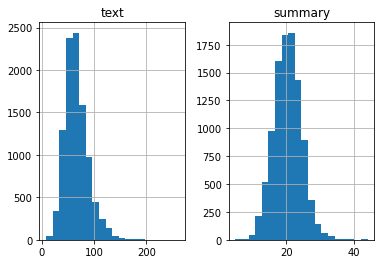

In [ ]:
text_count = []
summary_count = []

for t in train_df['input_text']:
    text_count.append(len(t.split()))
for t in train_df['target_text']:
    summary_count.append(len(t.split()))

graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

graph_df.hist(bins = 20)
plt.show()

In [ ]:
#Check how much % of text have 0-95 words
cnt=0
for i in train_df['input_text']:
    if(len(i.split())<=95):
        cnt=cnt+1
print(cnt/len(train_df['input_text']))

0.9007305113579506


In [ ]:
#Check how much % of summary have 0-40 words
cnt=0
for i in train_df['target_text']:
    if(0 <= len(i.split())<=25):
        cnt=cnt+1
print(cnt/len(train_df['target_text']))

0.902731912338637


In [ ]:
# prisrtkdsfs

In [ ]:
max_seq_length = 90
max_length = 25

### Building Transformers models

In [ ]:
def model_transformers(epochs, train_batch_size,eval_batch_size,max_seq_length,max_length,repetition_penalty):
  model_args = Seq2SeqArgs()
  model_args.num_train_epochs = epochs
  model_args.no_save = True
  model_args.evaluate_generated_text = True
  model_args.evaluate_during_training = False
  model_args.evaluate_during_training_verbose = False
  model_args.overwrite_output_dir = True
  model_args.train_batch_size = train_batch_size
  model_args.eval_batch_size = eval_batch_size
  model_args.max_seq_length = max_seq_length
  model_args.max_length = max_length
  model_args.early_stopping = False
  model_args.do_sample = True
  model_args.repetition_penalty = repetition_penalty


  model = Seq2SeqModel(
  encoder_decoder_type='bart',
  encoder_decoder_name='facebook/bart-large-cnn',
  args=model_args,
  use_cuda=True,
  )
  return model

## Evaluation Metric

### The following code is adapted from https://pypi.org/project/py-rouge/

In [ ]:
def rouge_eval(x,y):
  evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                          max_n=2,
                          limit_length=True,
                          length_limit=100,
                          length_limit_type='words',
                          apply_avg=True,
                          # apply_best=apply_best,
                          alpha=0.5, # Default F1_score
                          weight_factor=1.2,
                          stemming=True)
  scores  = evaluator.get_scores(x,y)
  return [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], scores['rouge-w']['f']]


In [ ]:
def rouge_eval2(x,y):
  evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                          max_n=2,
                          limit_length=True,
                          length_limit=100,
                          length_limit_type='words',
                          apply_avg=True,
                          # apply_best=apply_best,
                          alpha=0.5, # Default F1_score
                          weight_factor=1.2,
                          stemming=True)
  scores  = evaluator.get_scores(x,y)
  return np.sum([scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], scores['rouge-w']['f']])


In [ ]:
def bert_score(x,y):
  # print(x)
  # print(y)
  F1 = score(y,x, lang="en", verbose=False)[2]
  return F1

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
x = torch.tensor([3,5])
print(x.numpy().mean())
x

4.0


tensor([3, 5])

## Training and Hyperparameter tuning with the validation dataset

In [ ]:
def objective_func_TRA(args):

  repetition_penalty = args['repetition_penalty']

  par_dict = {'repetition_penalty': repetition_penalty}
  print(par_dict)

  model = model_transformers(10, 32,16,max_seq_length,max_length,repetition_penalty)
  model.train_model(train_df)
  eval_score = (model.eval_model(val_df, output_dir=None, verbose=False, silent=True, bertscore = bert_score)['bertscore']).numpy().mean()
  print(eval_score)

  return -(eval_score)

space = {'repetition_penalty': hp.uniform('repetition_penalty',1, 4)
        }                  
                                                                 
best_TRA = fmin(objective_func_TRA, space, algo=tpe.suggest, max_evals=4)
print(best_TRA)

{'repetition_penalty': 2.1754180658944793}
  0%|          | 0/4 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



0.8481147
{'repetition_penalty': 3.719648262281222}
 25%|██▌       | 1/4 [21:54<1:05:43, 1314.52s/it, best loss: -0.8481147289276123]

Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f219a5e9e48>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers

w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join

assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError
: 
can only join a child process
Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f219a5e9e48>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shu

0.84806937
{'repetition_penalty': 1.1207647586074643}
 50%|█████     | 2/4 [43:47<43:48, 1314.16s/it, best loss: -0.8481147289276123]

0.84954673
{'repetition_penalty': 1.9800090611068382}
 75%|███████▌  | 3/4 [1:04:52<21:39, 1299.28s/it, best loss: -0.8495467305183411]

Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f25171044a8>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers

w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join

assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError
: 
can only join a child process
Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f2511579898>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shu

0.84862757
100%|██████████| 4/4 [1:25:26<00:00, 1281.54s/it, best loss: -0.8495467305183411]
{'repetition_penalty': 1.1207647586074643}


In [ ]:
# def objective_func_TRA(args):

#   max_seq_length = args['max_seq_length']
#   max_length = args['max_length']
#   repetition_penalty = args['repetition_penalty']

#   par_dict = {'max_length': max_length, 'max_seq_length': max_seq_length, 'repetition_penalty': repetition_penalty}
#   print(par_dict)

#   model = model_transformers(10, 32,16,max_seq_length,max_length,repetition_penalty)
#   model.train_model(train_df)
#   eval_score = (model.eval_model(val_df, output_dir=None, verbose=False, silent=True, bertscore = bert_score)['bertscore']).numpy().mean()
#   print(eval_score)

#   return -(eval_score)

# space = {'max_length': hp.choice('max_length',[10,20,30]),  
#          'max_seq_length': hp.choice('max_seq_length',[20,40, 60, 80]),
#          'repetition_penalty': hp.uniform('repetition_penalty',1, 4)
#         }                  
                                                                 
# best_TRA = fmin(objective_func_TRA, space, algo=tpe.suggest, max_evals=10)
# print(best_TRA)

In [ ]:
{'repetition_penalty': 1.1207647586074643}
best_bert= 0.849546730518341

In [ ]:
print(dadafd)

NameError: ignored

In [ ]:

repetition_penalty = 3.23
par_dict = {'max_length': max_length, 'max_seq_length': max_seq_length, 'repetition_penalty': repetition_penalty}
print(par_dict)

model = model_transformers(10, 32,16,max_seq_length,max_length,repetition_penalty)
model.train_model(train_df)
# eval_score = model.eval_model(val_df, output_dir=None, verbose=False, silent=True, bertscore = bert_score)['bertscore']
# print(eval_score)

In [ ]:
y_pred  = model.predict(val_df['input_text'])

In [ ]:
y_pred[0]

In [ ]:
score(y_pred, list(val_df['target_text']), lang="en", verbose=True)[2].numpy().mean()

In [ ]:
pred_path = r'/content/drive/Shared drives/CS594 DNLP Project/Predictions/3/Validation'

In [ ]:
def pred_save(filename, y_pred):
  pred_df = pd.DataFrame()
  pred_df['Actual Summary'] = val_df['target_text']
  pred_df['Predicted Summary'] = y_pred
  pred_df.to_csv(os.path.join(pred_path,filename))

In [ ]:
pred_save('predicitions 333 bertscore repp 3.23.csv', y_pred)